# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Import packages

In [37]:
from __future__ import annotations

In [38]:
! python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 61.3 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [39]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [40]:
# sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

## Load Data

In [41]:
df = pd.read_csv(
    'data/reviews.csv',
)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1


## Data Exploration

In [42]:
df.shape

(18442, 9)

In [43]:
df.describe()

,Clothing ID,Age,Positive Feedback Count,Recommended IND
count,18442.000000,18442.000000,18442.000000,18442.000000
mean,954.896757,43.383635,2.697484,0.816235
std,141.571783,12.246264,5.942220,0.387303
min,2.000000,18.000000,0.000000,0.000000
25%,863.000000,34.000000,0.000000,1.000000
50%,952.000000,41.000000,1.000000,1.000000
75%,1078.000000,52.000000,3.000000,1.000000
max,1205.000000,99.000000,122.000000,1.000000


In [44]:
df.nunique()

Clothing ID                  531
Age                           77
Title                      13142
Review Text                18439
Positive Feedback Count       79
Division Name                  2
Department Name                6
Class Name                    14
Recommended IND                2
dtype: int64

In [45]:
df.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
Recommended IND             int64
dtype: object

#### Change column names

In [46]:
df.rename(columns={'Clothing ID': 'Clothing_ID', 'Review Text': 'Review_Text',
                  'Positive Feedback Count': 'Positive_Feedback_Count', 'Division Name': 'Division_Name',
                  'Department Name': 'Department_Name', 'Class Name': 'Class_Name',
                  'Recommended IND': 'Recommended_IND'}, inplace=True)

#### Unique values for categorical variables

In [47]:
cat_list = ('Division_Name', 'Department_Name', 'Class_Name')
cat_list

('Division_Name', 'Department_Name', 'Class_Name')

In [48]:
for col in cat_list:
    print(df[col].value_counts())

Division_Name
General           11664
General Petite     6778
Name: count, dtype: int64
Department_Name
Tops        8713
Dresses     5371
Bottoms     3184
Jackets      879
Intimate     188
Trend        107
Name: count, dtype: int64
Class_Name
Dresses           5371
Knits             3981
Blouses           2587
Sweaters          1218
Pants             1157
Jeans              970
Fine gauge         927
Skirts             796
Jackets            598
Outerwear          281
Shorts             260
Lounge             188
Trend              107
Casual bottoms       1
Name: count, dtype: int64


#### Graphs

In [49]:
# plot count plot

def get_countplot(dataframe, column, title):
    
    """display count plot for a column
    column - input variable, column name to plot
    dataframe - data frame to use
    title - graph title
    """
    ax= sns.countplot(dataframe, x=column, order = dataframe[column].value_counts().index, stat="percent")
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
        
    plt.title(title)
    plt.xticks(rotation=90);

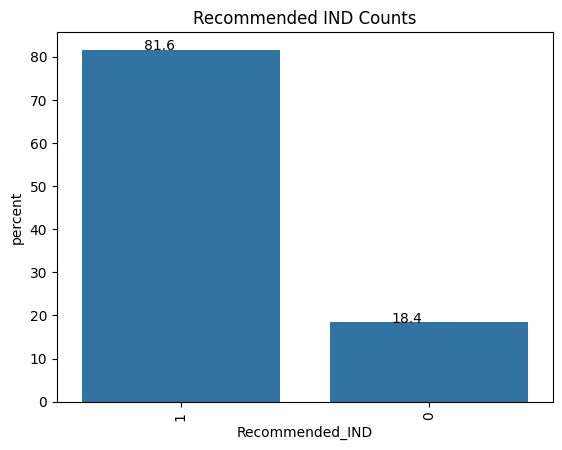

In [50]:
get_countplot(df, 'Recommended_IND', 'Recommended IND Counts')

Only 18.4% of reviews ends with recommendation. Dataset is imbalanced.

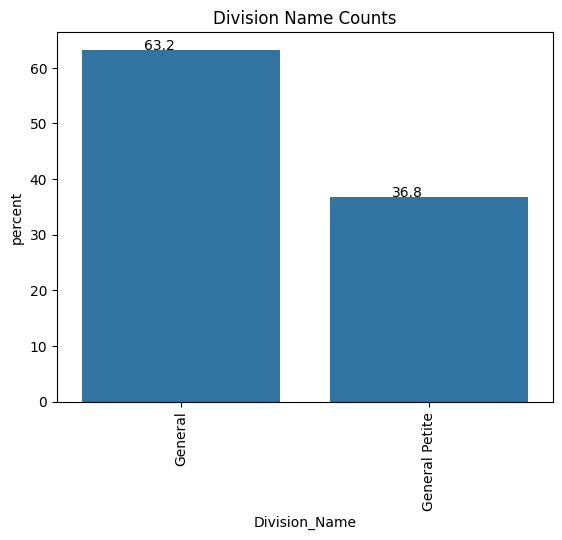

In [51]:
get_countplot(df, 'Division_Name', 'Division Name Counts')

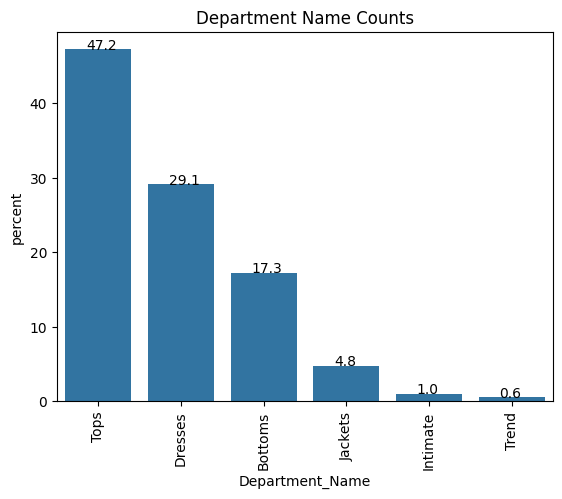

In [52]:
get_countplot(df, 'Department_Name', 'Department Name Counts')

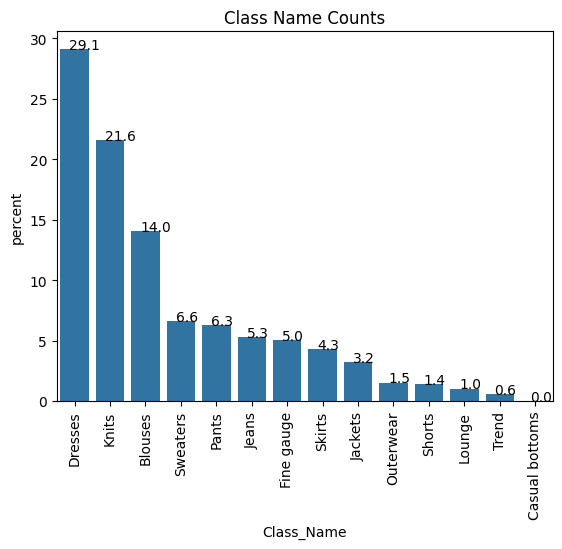

In [53]:
get_countplot(df, 'Class_Name', 'Class Name Counts')

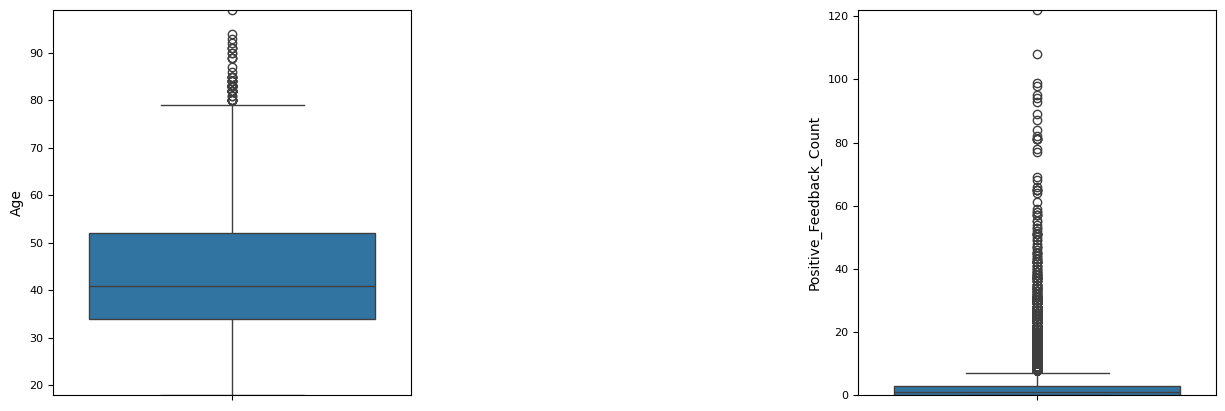

In [54]:
# Boxplot for 'Age'
selection = ['Age', 'Positive_Feedback_Count']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, col in enumerate(selection):
    ax = sns.boxplot(y=df[col], ax=axes.flatten()[i])
    ax.set_ylim(df[col].min(), df[col].max())
    ax.set_ylabel(col)
    ax.yaxis.set_tick_params(labelsize=8)

plt.subplots_adjust(hspace=0.15, wspace=1.25)
# plt.figure(figsize=(20,12))
     
plt.show();

##### Histogram

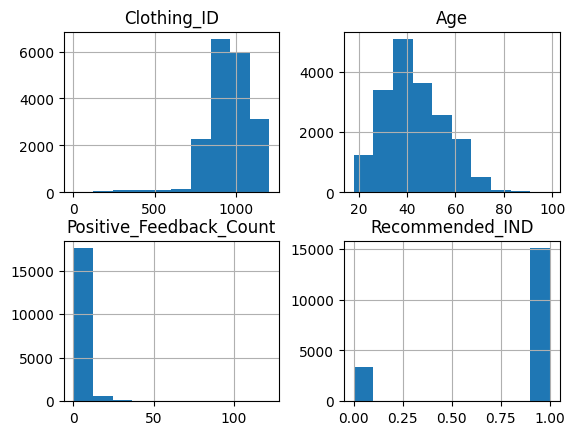

In [55]:
df.hist();

Clothing ID should be treated as categorical variable. According to features description it shoudn't have numerical order. Treating it as numeric can lead  to incorrect results. As there are 531 I will drop this column from analysis. 

##### Boxplot: 'Age', 'Positive Feedback Count' vs Target

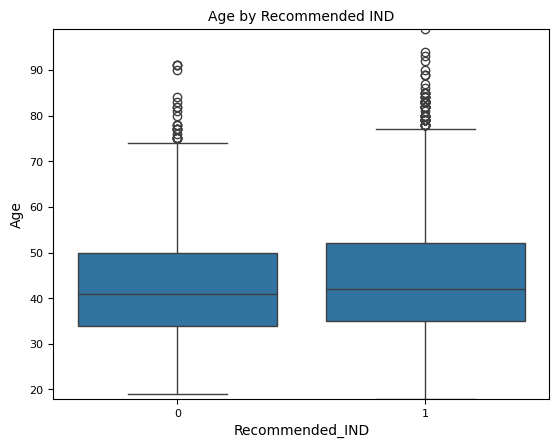

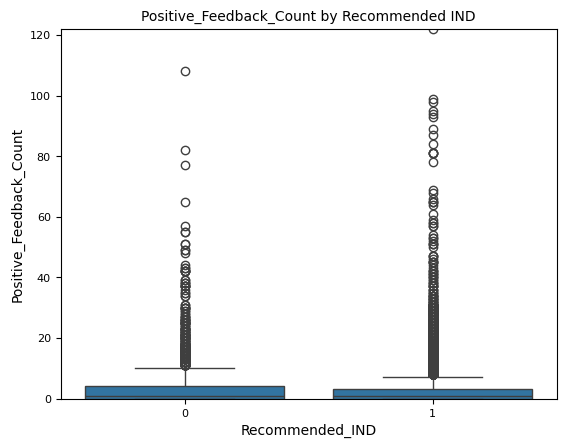

In [56]:
selection = ['Age', 'Positive_Feedback_Count']

for col in (selection):
    
   
    df_boxplot=pd.melt(df,id_vars=['Recommended_IND'],value_vars=[col],var_name= col+' by Recommended IND')
    ax = sns.boxplot(x='Recommended_IND',y='value',data=df_boxplot,hue=col+' by Recommended IND', legend = 0)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.xaxis.set_tick_params(labelsize=8)

    ax.set_ylim(df[col].min(), df[col].max())
    ax.set_ylabel(col)
    ax.yaxis.set_tick_params(labelsize=8)

    plt.title(col+' by Recommended IND', fontsize = 10); 
    plt.show();

##### Target variable vs categorical variables graphs

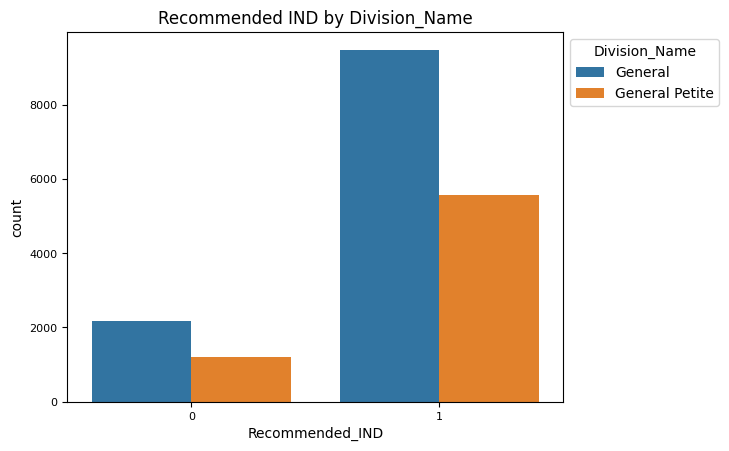

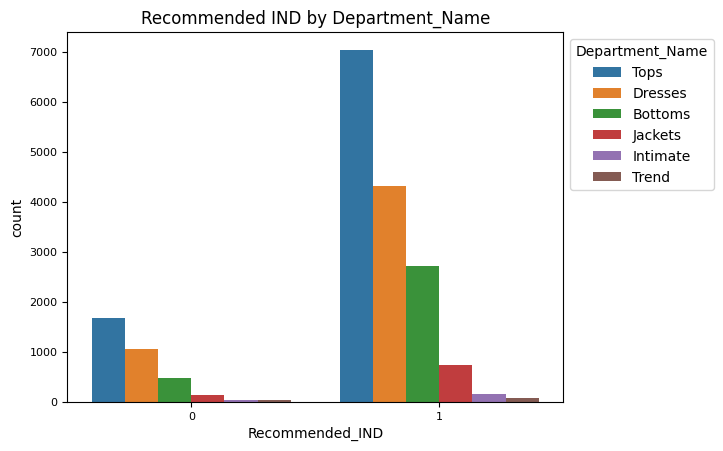

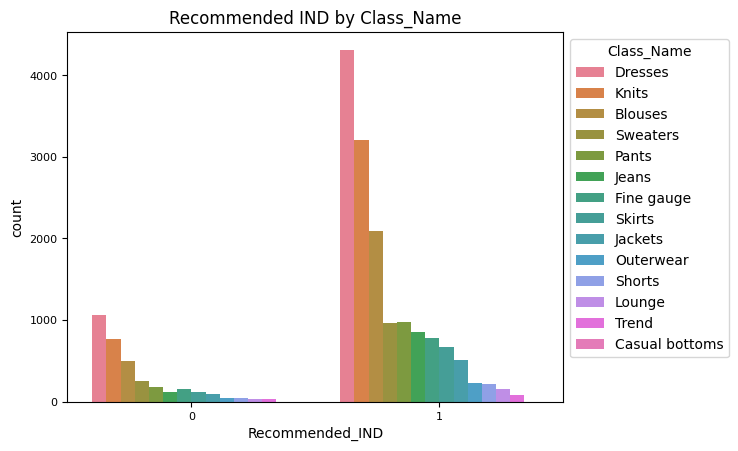

In [57]:
selection = ['Division_Name', 'Department_Name', 'Class_Name']

for col in (selection):
    ax = sns.countplot(data = df, x = 'Recommended_IND', hue = col, hue_order=df[col].value_counts().index)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.xaxis.set_tick_params(labelsize=8)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title('Recommended IND by '+col)
    plt.show();

## Preparing features (`X`) & target (`y`)

In [58]:
data = df

# separate features from labels
X = data.drop('Recommended_IND', axis=1)
y = data['Recommended_IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing_ID,Age,Title,Review_Text,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [59]:
# Split data into train and test sets using stratified sampling as dataset is imbalanced.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
    stratify = y
)

## Building Pipeline

In [60]:
# Split data into numerical, categorical, and text features

num_features = (
    X
    .select_dtypes(exclude=['object']).columns
    .drop(
        [
            'Clothing_ID', # More of category than a numerical feature
        ],
    )
)
print('Numerical features:', num_features)

cat_features = (
    X[[
#         'Clothing_ID',
        'Division_Name',
        'Department_Name',
        'Class_Name'
    ]].columns
)
print('Categorical features:', cat_features)


text_features1 = (
    X[[
#         'Title',
        'Review_Text'
    ]].columns
)
print ('Review Text features 1:', text_features1)

text_features2 = (
    X[[
        'Title',
#         'Review_Text'
    ]].columns
)
print ('Review Text features 2:', text_features2)

Numerical features: Index(['Age', 'Positive_Feedback_Count'], dtype='object')
Categorical features: Index(['Division_Name', 'Department_Name', 'Class_Name'], dtype='object')
Review Text features 1: Index(['Review_Text'], dtype='object')
Review Text features 2: Index(['Title'], dtype='object')


#### Numerical Features Pipeline

In [61]:
# MinMaxScaler doesn’t reduce the effect of outliers, but it linearly scales them down into a fixed range, 
# where the largest occurring data point corresponds to the maximum value and the smallest one corresponds to the minimum value.

# QuantileTransformer QuantileTransformer are robust to outliers in the sense that adding or removing outliers 
# in the training set will yield approximately the same transformation. 
# But contrary to RobustScaler, QuantileTransformer will also automatically collapse any 
# outlier by setting them to the a priori defined range boundaries (0 and 1). 
# This can result in saturation artifacts for extreme values.

num_pipeline = Pipeline([
    (
        'q_scaler',
        QuantileTransformer(),
    ),
    (
        'scaler',
        MinMaxScaler(),
    ),
])

num_pipeline

Pipeline(steps=[('q_scaler', QuantileTransformer()),
                ('scaler', MinMaxScaler())])

#### Categorical Features Pipeline

In [62]:
# Define pipeline for categorical features

cat_pipeline = Pipeline([
#     (
#         'ordinal_encoder',
#         OrdinalEncoder(
#             handle_unknown='use_encoded_value',
#             unknown_value=-1,
#         )
#     ),    
    (
        'cat_encoder',
        OneHotEncoder(
            sparse_output=False,
            handle_unknown='ignore',
        )
    ),
])

cat_pipeline

Pipeline(steps=[('cat_encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

#### Text Features Pipeline

In [63]:
from sklearn.base import BaseEstimator, TransformerMixin
# Create CountCharacter()
# Takes in a string for the character to count
# Outputs the number times that character appears in the text

class CountCharacter(BaseEstimator, TransformerMixin):
    def __init__(self, character: str):
        self.character = character

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [[text.count(self.character)] for text in X]

In [64]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
import numpy as np
# Use initial_text_preprocess to make sure the text is in the expected shape for CountCharacter()

initial_text_preprocess = Pipeline([
    (
        'dimension_reshaper',
        FunctionTransformer(
            np.reshape,
            kw_args={'newshape':-1},
        ),
    ),
])

In [65]:
# Create a pipeline for counting the number of spaces, `!`, and `?`

feature_engineering = FeatureUnion([
    ('count_spaces', CountCharacter(character=' ')),
    ('count_exclamations', CountCharacter(character='!')),
    ('count_question_marks', CountCharacter(character='?')),
])

character_counts_pipeline = Pipeline([
    (
        'initial_text_preprocess',
        initial_text_preprocess,
    ),
    (
        'feature_engineering',
        feature_engineering,
    ),
])
character_counts_pipeline

Pipeline(steps=[('initial_text_preprocess',
                 Pipeline(steps=[('dimension_reshaper',
                                  FunctionTransformer(func=<function reshape at 0x78390019aaf0>,
                                                      kw_args={'newshape': -1}))])),
                ('feature_engineering',
                 FeatureUnion(transformer_list=[('count_spaces',
                                                 CountCharacter(character=' ')),
                                                ('count_exclamations',
                                                 CountCharacter(character='!')),
                                                ('count_question_marks',
                                                 CountCharacter(character='?'))]))])

In [66]:
# Create SpacyLemmatizer
# It will simplify the text. This way words like 'good' and 'better' are converted to the same value. 
# This representation will carry over into TF-IDF.
class SpacyLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lemmatized = [
            ' '.join(
                token.lemma_ for token in doc
                if not token.is_stop
            )
            for doc in self.nlp.pipe(X)
        ]
        return lemmatized  

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Use TF-IDF to get a vector representation of the review text.

tfidf_pipeline = Pipeline([
    (
        'dimension_reshaper',
        FunctionTransformer(
            np.reshape,
            kw_args={'newshape':-1},
        ),
    ),
    (
        'lemmatizer',
        SpacyLemmatizer(nlp=nlp),
    ),
    (
        'tfidf_vectorizer',
        TfidfVectorizer(
            stop_words='english',
        ),
    ),
])
tfidf_pipeline 

Pipeline(steps=[('dimension_reshaper',
                 FunctionTransformer(func=<function reshape at 0x78390019aaf0>,
                                     kw_args={'newshape': -1})),
                ('lemmatizer',
                 SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x783891bb94b0>)),
                ('tfidf_vectorizer', TfidfVectorizer(stop_words='english'))])

#### Combine Feature Engineering Pipelines

In [68]:
from sklearn.compose import ColumnTransformer

feature_engineering = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features),
        ('character_counts1', character_counts_pipeline, text_features1),
        ('character_counts2', character_counts_pipeline, text_features2),
        ('tfidf_text1', tfidf_pipeline, text_features1),
        ('tfidf_text2', tfidf_pipeline, text_features2),
])

feature_engineering

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('q_scaler',
                                                  QuantileTransformer()),
                                                 ('scaler', MinMaxScaler())]),
                                 Index(['Age', 'Positive_Feedback_Count'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Division_Name', 'Department_Name', 'Class_Name'], dtype='object')),
                                ('c...
                                 Index(['Review_Text'], dtype='object')),
                                ('tfidf_text2',
                                 Pipeline(steps=[('dimension_reshaper',
                                                  FunctionTransformer(func=<function reshape at 0x78390019aaf0>,
                                                                      kw_args={'newshape': -1})),
                                                 ('lemmatizer',
                                                  SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x783891bb94b0>)),
                                                 ('tfidf_vectorizer',
                                                  TfidfVectorizer(stop_words='english'))]),
                                 Index(['Title'], dtype='object'))])

## Training Pipeline

I will test 3 models: RandomForestClassifier, GradientBoostingClassifier and AdaBoostClassifier. Those models will be later evaluated and the best model will be tuned.

In [69]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import make_pipeline

model_pipeline = make_pipeline(
    feature_engineering,
    RandomForestClassifier(random_state=27),
)

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('q_scaler',
                                                                   QuantileTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Positive_Feedback_Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Division_Name', 'Department_Nam...
                                                  Pipeline(steps=[('dimension_reshaper',
                                                                   FunctionTransformer(func=<function reshape at 0x78390019aaf0>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x783891bb94b0>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  Index(['Title'], dtype='object'))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=27))])

In [70]:
model_pipeline2 = make_pipeline(
    feature_engineering,
    GradientBoostingClassifier(random_state=27),
)

model_pipeline2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('q_scaler',
                                                                   QuantileTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Positive_Feedback_Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Division_Name', 'Department_Nam...
                                                  Pipeline(steps=[('dimension_reshaper',
                                                                   FunctionTransformer(func=<function reshape at 0x78390019aaf0>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x783891bb94b0>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  Index(['Title'], dtype='object'))])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=27))])

In [71]:
model_pipeline3 = make_pipeline(
    feature_engineering,
    AdaBoostClassifier(random_state=27),
)

model_pipeline3.fit(X_train, y_train)

/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('q_scaler',
                                                                   QuantileTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Positive_Feedback_Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Division_Name', 'Department_Nam...
                                                  Pipeline(steps=[('dimension_reshaper',
                                                                   FunctionTransformer(func=<function reshape at 0x78390019aaf0>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x783891bb94b0>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  Index(['Title'], dtype='object'))])),
                ('adaboostclassifier', AdaBoostClassifier(random_state=27))])

## Evaluate Model

 As the dataset is imbalanced I will use F1 score and average_precision_score to evaluate models.

In [74]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score

y_pred_forest_pipeline = model_pipeline.predict(X_test)
average_precision_score_forest_pipeline = average_precision_score(y_test, y_pred_forest_pipeline)
f1_forest_pipeline = f1_score(y_test, y_pred_forest_pipeline)

print('Random Forest Classifier')
print('average_precision_score:', average_precision_score_forest_pipeline)
print('f1_score:', f1_forest_pipeline)

Random Forest Classifier
average_precision_score: 0.8523414546957044
f1_score: 0.9167945962542217


In [75]:
y_pred_forest_pipeline = model_pipeline2.predict(X_test)
average_precision_score_forest_pipeline = average_precision_score(y_test, y_pred_forest_pipeline)
f1_forest_pipeline = f1_score(y_test, y_pred_forest_pipeline)

print('GradientBoostingClassifier')
print('average_precision_score:', average_precision_score_forest_pipeline)
print('f1_score:', f1_forest_pipeline)

GradientBoostingClassifier
average_precision_score: 0.861235401831622
f1_score: 0.9173399627097576


In [76]:
y_pred_forest_pipeline = model_pipeline3.predict(X_test)
average_precision_score_forest_pipeline = average_precision_score(y_test, y_pred_forest_pipeline)
f1_forest_pipeline = f1_score(y_test, y_pred_forest_pipeline)

print('AdaBoostClassifier')
print('average_precision_score:', average_precision_score_forest_pipeline)
print('f1_score:', f1_forest_pipeline)

AdaBoostClassifier
average_precision_score: 0.8798333588664109
f1_score: 0.9137544084642514


I will tune AdaBoostClassifier as average_precision_score for this model is the best

## Fine-Tuning Pipeline

In [79]:
from sklearn.model_selection import RandomizedSearchCV

# TODO: set parameters to randomly search over
# A couple parameters with 2-5 options each is plenty
my_distributions = dict(
    adaboostclassifier__n_estimators=[
        150,
        200,
    ],
    adaboostclassifier__learning_rate=[
        0.3,
        0.5,
        1
    ],
)

param_search = RandomizedSearchCV(
    estimator=model_pipeline3,
    param_distributions=my_distributions,
    n_iter=6,     # Try 6 different combinations of parameters
    cv=5,         # Use 5-fold cross-validation
    n_jobs=-1,    # Use all available processors (for multiprocessing)
    refit=True,   # Refit the model using the best parameters found
    verbose=3,    # Output of parameters, score, time
    random_state=27,
)

param_search.fit(X_train, y_train)

# Retrieve the best parameters
param_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END adaboostclassifier__learning_rate=0.3, adaboostclassifier__n_estimators=150;, score=0.862 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END adaboostclassifier__learning_rate=0.3, adaboostclassifier__n_estimators=150;, score=0.862 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END adaboostclassifier__learning_rate=0.3, adaboostclassifier__n_estimators=150;, score=0.865 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END adaboostclassifier__learning_rate=0.3, adaboostclassifier__n_estimators=150;, score=0.867 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END adaboostclassifier__learning_rate=0.3, adaboostclassifier__n_estimators=150;, score=0.863 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END adaboostclassifier__learning_rate=0.3, adaboostclassifier__n_estimators=200;, score=0.869 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END adaboostclassifier__learning_rate=0.3, adaboostclassifier__n_estimators=200;, score=0.874 total time= 1.9min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END adaboostclassifier__learning_rate=0.3, adaboostclassifier__n_estimators=200;, score=0.874 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END adaboostclassifier__learning_rate=0.3, adaboostclassifier__n_estimators=200;, score=0.872 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END adaboostclassifier__learning_rate=0.3, adaboostclassifier__n_estimators=200;, score=0.870 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END adaboostclassifier__learning_rate=0.5, adaboostclassifier__n_estimators=150;, score=0.870 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END adaboostclassifier__learning_rate=0.5, adaboostclassifier__n_estimators=150;, score=0.875 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END adaboostclassifier__learning_rate=0.5, adaboostclassifier__n_estimators=150;, score=0.878 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END adaboostclassifier__learning_rate=0.5, adaboostclassifier__n_estimators=150;, score=0.879 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END adaboostclassifier__learning_rate=0.5, adaboostclassifier__n_estimators=200;, score=0.878 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END adaboostclassifier__learning_rate=0.5, adaboostclassifier__n_estimators=200;, score=0.880 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END adaboostclassifier__learning_rate=0.5, adaboostclassifier__n_estimators=200;, score=0.885 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END adaboostclassifier__learning_rate=0.5, adaboostclassifier__n_estimators=200;, score=0.888 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END adaboostclassifier__learning_rate=0.5, adaboostclassifier__n_estimators=200;, score=0.883 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END adaboostclassifier__learning_rate=1, adaboostclassifier__n_estimators=150;, score=0.871 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END adaboostclassifier__learning_rate=1, adaboostclassifier__n_estimators=150;, score=0.875 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END adaboostclassifier__learning_rate=1, adaboostclassifier__n_estimators=150;, score=0.885 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END adaboostclassifier__learning_rate=1, adaboostclassifier__n_estimators=150;, score=0.884 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END adaboostclassifier__learning_rate=1, adaboostclassifier__n_estimators=150;, score=0.882 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 1/5] END adaboostclassifier__learning_rate=1, adaboostclassifier__n_estimators=200;, score=0.868 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 2/5] END adaboostclassifier__learning_rate=1, adaboostclassifier__n_estimators=200;, score=0.880 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 3/5] END adaboostclassifier__learning_rate=1, adaboostclassifier__n_estimators=200;, score=0.888 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 4/5] END adaboostclassifier__learning_rate=1, adaboostclassifier__n_estimators=200;, score=0.884 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV 5/5] END adaboostclassifier__learning_rate=1, adaboostclassifier__n_estimators=200;, score=0.881 total time= 1.8min


/opt/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


{'adaboostclassifier__n_estimators': 200,
 'adaboostclassifier__learning_rate': 0.5}

In [80]:
model_best = param_search.best_estimator_
model_best

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('q_scaler',
                                                                   QuantileTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['Age', 'Positive_Feedback_Count'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Division_Name', 'Department_Nam...
                                                                   FunctionTransformer(func=<function reshape at 0x78390019aaf0>,
                                                                                       kw_args={'newshape': -1})),
                                                                  ('lemmatizer',
                                                                   SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x7838a1795ed0>)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(stop_words='english'))]),
                                                  Index(['Title'], dtype='object'))])),
                ('adaboostclassifier',
                 AdaBoostClassifier(learning_rate=0.5, n_estimators=200,
                                    random_state=27))])

In [81]:
y_pred_forest_pipeline = model_best.predict(X_test)

average_precision_score_forest_pipeline = average_precision_score(y_test, y_pred_forest_pipeline)
f1_forest_pipeline = f1_score(y_test, y_pred_forest_pipeline)

print('AdaBoostClassifier best model')
print('average_precision_score:', average_precision_score_forest_pipeline)
print('f1_score:', f1_forest_pipeline)

AdaBoostClassifier best model
average_precision_score: 0.888994661002094
f1_score: 0.9273422562141491
